In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import logging
logging.Logger.disabled=True

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='DEBUG')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

2021-03-20 13:18:01,671 - PySpice.Spice.Netlist.__new__ - DEBUG - Element don't define a __pins__ attribute
2021-03-20 13:18:01,673 - PySpice.Spice.Netlist.__new__ - DEBUG - FixedPinElement don't define a __pins__ attribute
2021-03-20 13:18:01,676 - PySpice.Spice.Netlist.__new__ - DEBUG - SubCircuitElement don't define a __pins__ attribute
2021-03-20 13:18:01,680 - PySpice.Spice.Netlist.__new__ - DEBUG - Resistor don't define a __pins__ attribute
2021-03-20 13:18:01,682 - PySpice.Spice.Netlist.__new__ - DEBUG - SemiconductorResistor don't define a __pins__ attribute
2021-03-20 13:18:01,684 - PySpice.Spice.Netlist.__new__ - DEBUG - BehavioralResistor don't define a __pins__ attribute
2021-03-20 13:18:01,686 - PySpice.Spice.Netlist.__new__ - DEBUG - Capacitor don't define a __pins__ attribute
2021-03-20 13:18:01,691 - PySpice.Spice.Netlist.__new__ - DEBUG - SemiconductorCapacitor don't define a __pins__ attribute
2021-03-20 13:18:01,693 - PySpice.Spice.Netlist.__new__ - DEBUG - Behaviora

In [2]:
class VoltageDivider1(SubCircuitFactory):
    __name__ = 'voltage_divider_1'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

class VoltageDivider2(SubCircuitFactory):
    __name__ = 'voltage_divider_2'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

class VoltageDivider3(SubCircuitFactory):
    __name__ = 'voltage_divider_3'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )


# low pass filter
{: class="subtitle is-lowercase"}

lets get started with the simplest filter, a low pass filter.  




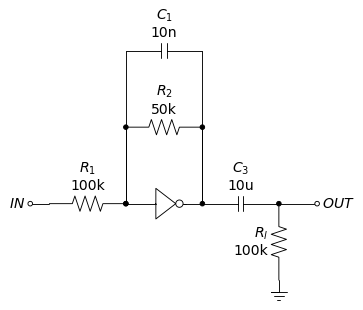

In [3]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

d.add(elm.Dot(open=True, lftlabel='$IN$'))
d.add(elm.Line('right', l=d.unit/4))
d.add(elm.Resistor('right', label='$R_1$\n100k'))
N1 = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_3$\n10u'))
d.add(elm.Resistor("down",label='$R_l$\n100k'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit))
d.add(logic.Dot())
d.add(elm.Resistor('right', label='$R_2$\n50k'))
d.add(logic.Dot())
d.add(elm.Line('down', l=d.unit))
d.add(logic.Dot())

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit*2))
d.add(elm.Capacitor('right', label='$C_1$\n10n'))
d.add(elm.Line('down', l=d.unit*2))

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Dot(open=True, rgtlabel='$OUT$'))

d.draw()

In [4]:
circuit = Circuit('cmos low pass filter')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2V SIN(0 2V 100)')

circuit.R(1, 'IN', 'gate_in_1', 100@u_kΩ)
#circuit.C('in1', 'r_in', 'gate_in_1', 47@u_nF)
circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.R(2, 'gate_in_1', 'gate_out_1', 100@u_kΩ)
circuit.C(2, 'gate_in_1', 'gate_out_1', 10@u_nF)
circuit.C(3, 'gate_out_1', 'OUT', 10@u_uF)
circuit.R('load', 'OUT', circuit.gnd, 100@u_kOhm);

In [5]:
freq = 1 / (2 * np.pi * float(100@u_kΩ) * float(10@u_nF));
#print( freq )

for this filter we expect the cutoff frequency to be:


$$
\begin{array}{c}
f = \frac{1}{2 \pi RC} = \frac{1}{2 \pi 100k * 100n} = 159Hz
\end{array}
$$


In [6]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_kHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=10@u_ms, end_time=20@u_ms);

2021-03-20 13:18:04,941 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.new_instance - DEBUG - New instance for id 0
2021-03-20 13:18:04,943 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._load_library - DEBUG - Set locale LC_NUMERIC to C
2021-03-20 13:18:05,059 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._load_library - DEBUG - Load library libngspice.so
2021-03-20 13:18:05,140 - PySpice.Spice.NgSpice.Shared._send_char - DEBUG - b'stdout ******'
2021-03-20 13:18:05,142 - PySpice.Spice.NgSpice.Shared._send_char - DEBUG - b'stdout ** ngspice-32 shared library'
2021-03-20 13:18:05,144 - PySpice.Spice.NgSpice.Shared._send_char - DEBUG - b'stdout ** Creation Date: Tue Jun  9 21:35:26 UTC 2020'
2021-03-20 13:18:05,146 - PySpice.Spice.NgSpice.Shared._send_char - DEBUG - b'stdout ******'
2021-03-20 13:18:05,157 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: version -f
2021-03-20 13:18:05,161 - PySpice.Spice.NgSpice.Shared._send_char - DEBUG - b'stdout ******'

2021-03-20 13:18:06,119 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:18:06,120 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:18:06,122 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


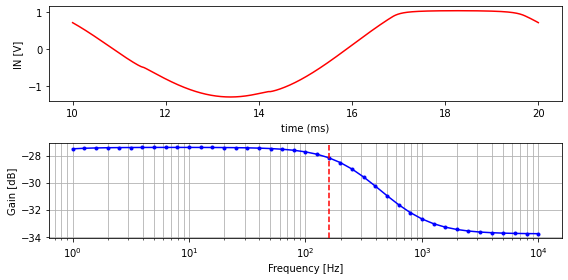

In [7]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['OUT'], color='Red')

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['OUT'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)
ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

# Band pass filter
{: class="subtitle is-lowercase"}



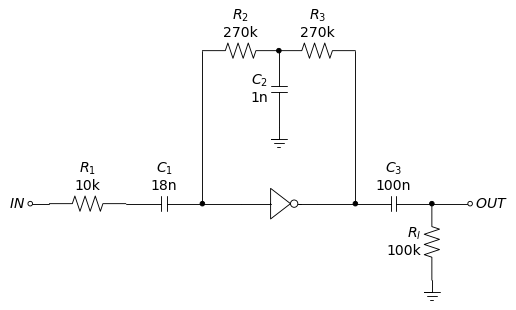

In [8]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

d.add(elm.Dot(open=True, lftlabel='$IN$'))
d.add(elm.Line('right', l=d.unit/4))
d.add(elm.Resistor('right', label='$R_1$\n10k'))
d.add(elm.Capacitor('right', label='$C_1$\n18n'))
N1start = d.add(elm.Line('right', l=d.unit/2))
d.add(logic.Not)
N1end = d.add(elm.Line('right', l=d.unit/2))
C = d.add(elm.Capacitor(label='$C_3$\n100n'))

d.add(elm.Resistor("down",label='$R_l$\n100k'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1start.start))
d.add(elm.Line('up', l=d.unit*2))
R2 = d.add(elm.Resistor('right', label='$R_2$\n270k'))
d.add(logic.Dot())
d.add(elm.Resistor('right', label='$R_3$\n270k'))
d.add(elm.Line('down', l=d.unit*2))
d.add(logic.Dot())

d.add(elm.Capacitor("down", label='$C_2$\n1n', at=R2.end))
d.add(elm.Ground)

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Dot(open=True, rgtlabel='$OUT$'))

d.draw()

In [9]:
circuit = Circuit('cmos band pass filter')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2V SIN(0 1V 100)')

circuit.R(1, 'IN', 'R1', 10@u_kΩ)
circuit.C(1, 'R1', 'gate_in_1', 18@u_nF)
circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.R(2, 'gate_in_1', 'R2', 270@u_kΩ)
circuit.C(2, 'R2', circuit.gnd, 1@u_nF)
circuit.R(3, 'gate_out_1', 'R2', 270@u_kΩ)
circuit.C(3, 'gate_out_1', 'OUT', 10@u_uF)
Rload = circuit.R('load', 'OUT', circuit.gnd, 100@u_kOhm);

In [10]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_kHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=10@u_ms, end_time=20@u_ms);

2021-03-20 13:18:09,914 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title cmos band pass filter
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 2V SIN(0 1V 100)
R1 IN R1 10kOhm
C1 R1 gate_in_1 18nF
X1 gate_in_1 gate_out_1 +5V 0 4069UB
R2 gate_in_1 R2 270kOhm
C2 R2 0 1nF
R3 gate_out_1 R2 270kOhm
C3 gate_out_1 OUT 10uF
Rload OUT 0 100kOhm
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 1Hz 100kHz
.end

2021-03-20 13:18:09,915 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2021-03-20 13:18:09,919 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.load_circuit - DEBUG - ngSpice_Circ
.title cmos band pass filter
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 2V SIN(0 1V 100)
R1 IN R1 10kOhm
C1 R1 gate_in_1 18nF
X1 gate_in_1 gate_out_1 +5V 0 4069UB
R2 gate_in_1 R2 270kOhm
C2 R2 0 1nF
R3 gate_ou

2021-03-20 13:18:10,884 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:18:10,886 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:18:10,891 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


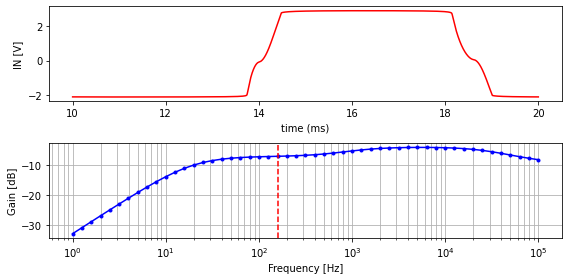

In [11]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['OUT'], color='Red')

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['OUT'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)
ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

# band pass filter


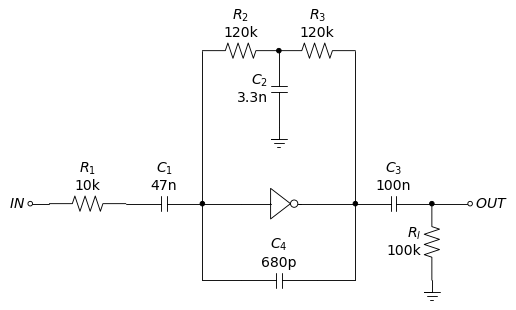

In [12]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

d.add(elm.Dot(open=True, lftlabel='$IN$'))
d.add(elm.Line('right', l=d.unit/4))
d.add(elm.Resistor('right', label='$R_1$\n10k'))
d.add(elm.Capacitor('right', label='$C_1$\n47n'))
N1start = d.add(elm.Line('right', l=d.unit/2))
d.add(logic.Not)
N1end = d.add(elm.Line('right', l=d.unit/2))
C = d.add(elm.Capacitor(label='$C_3$\n100n'))

d.add(elm.Resistor("down",label='$R_l$\n100k'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1start.start))
d.add(elm.Line('up', l=d.unit*2))
R2 = d.add(elm.Resistor('right', label='$R_2$\n120k'))
d.add(logic.Dot())
d.add(elm.Resistor('right', label='$R_3$\n120k'))
d.add(elm.Line('down', l=d.unit*2))
d.add(logic.Dot())

d.add(elm.Line('down', l=d.unit, at=N1start.start))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Capacitor('right', label='$C_4$\n680p'))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Line('up', l=d.unit))


d.add(elm.Capacitor("down", label='$C_2$\n3.3n', at=R2.end))
d.add(elm.Ground)

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Dot(open=True, rgtlabel='$OUT$'))

d.draw()

In [13]:
circuit = Circuit('cmos band pass filter')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 0.1V SIN(0 0.1V 100)')

circuit.R(1, 'IN', 'R1', 10@u_kΩ)
circuit.C(1, 'R1', 'gate_in_1', 47@u_nF)
circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.R(2, 'gate_in_1', 'R2', 120@u_kΩ)
circuit.C(2, 'R2', circuit.gnd, 3.3@u_nF)
circuit.R(3, 'gate_out_1', 'R2', 120@u_kΩ)
circuit.C(3, 'gate_out_1', 'OUT', 10@u_uF)
circuit.C(4, 'gate_in_1', 'gate_out_1', 680@u_pF)
Rload = circuit.R('load', 'OUT', circuit.gnd, 100@u_kOhm);

In [14]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_kHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=10@u_ms, end_time=20@u_ms);

2021-03-20 13:18:16,877 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title cmos band pass filter
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 0.1V SIN(0 0.1V 100)
R1 IN R1 10kOhm
C1 R1 gate_in_1 47nF
X1 gate_in_1 gate_out_1 +5V 0 4069UB
R2 gate_in_1 R2 120kOhm
C2 R2 0 3.3nF
R3 gate_out_1 R2 120kOhm
C3 gate_out_1 OUT 10uF
C4 gate_in_1 gate_out_1 680pF
Rload OUT 0 100kOhm
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 1Hz 100kHz
.end

2021-03-20 13:18:16,879 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2021-03-20 13:18:16,883 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.load_circuit - DEBUG - ngSpice_Circ
.title cmos band pass filter
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 0.1V SIN(0 0.1V 100)
R1 IN R1 10kOhm
C1 R1 gate_in_1 47nF
X1 gate_in_1 gate_out_1 +5V 0 4069UB
R2 gat

2021-03-20 13:18:17,541 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:18:17,543 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:18:17,544 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


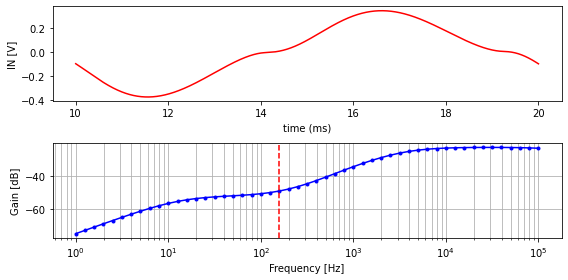

In [15]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['OUT'], color='Red')

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['OUT'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)
ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

## resonant low pass filter
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

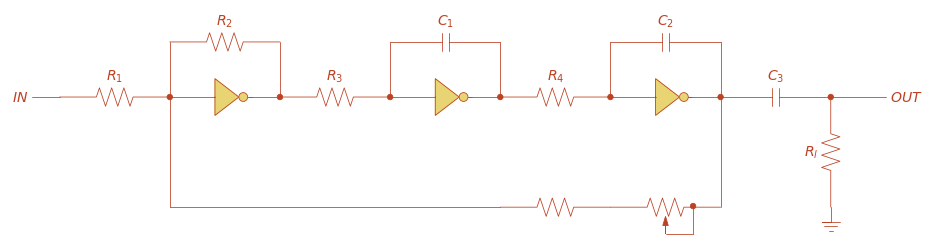

In [16]:
d = schemdraw.Drawing(inches_per_unit=0.6, color='#BD4224', lw=0.8, fill="#E8D473")

d.add(elm.Line('right', l=d.unit/4, lftlabel='$IN$'))
d.add(elm.Resistor('right', label='$R_1$'))
N1 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_3$'))
N2 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_4$'))
N3 = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_3$'))
d.add(elm.Resistor("down",label='$R_l$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N2.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Capacitor('right', label='$C_1$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N3.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Capacitor('right', label='$C_2$'))
d.add(elm.Line('down', l=d.unit/2))
D = d.add(logic.Dot())


d.add(elm.Line('down', l=d.unit, xy=D.start))
P = d.add(elm.Potentiometer('left'), label="$RV_1$")
d.add(elm.Resistor('left'), label="$R_5$")
d.add(elm.Line('left', l=3*d.unit))
d.add(elm.Line('up', l=d.unit))
d.add(elm.Line('right', l=d.unit/4, xy=P.tap))
d.add(elm.Line('up', l=d.unit/4))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2, rgtlabel='$OUT$'))
#d.add(elm.Line('right', l=d.unit, rgtlabel='$OUT$'))

d.draw()

In [17]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 100)')

circuit.R(1, 'IN', 'r_in', 100@u_kΩ)
circuit.C('in1', 'r_in', 'gate_in_1', 47@u_nF)
circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.R(2, 'gate_in_1', 'gate_out_1', 100@u_kΩ)
circuit.R(3, 'gate_out_1', 'gate_in_2', 20@u_kΩ)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.C(1, 'gate_in_2', 'gate_out_2', 100@u_nF)
circuit.R(4, 'gate_out_2', 'gate_in_3', 10@u_kΩ)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+5V', circuit.gnd)
circuit.C(2, 'gate_in_3', 'gate_out_3', 100@u_nF)
circuit.C(3, 'gate_out_3', 'OUT', 100@u_nF)
circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ);

In [18]:
#buffer_data = []
#for r in np.arange(100@u_kΩ, 200@u_kΩ, 25@u_kΩ):
#    circuit.R2.resistance = r

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms);
#buffer_data.append(np.array(analysis['OUT']));


2021-03-20 13:18:21,209 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title cmos buffer
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 2.5V SIN(0 2.5V 100)
R1 IN r_in 100kOhm
Cin1 r_in gate_in_1 47nF
X1 gate_in_1 gate_out_1 +5V 0 4069UB
R2 gate_in_1 gate_out_1 100kOhm
R3 gate_out_1 gate_in_2 20kOhm
X2 gate_in_2 gate_out_2 +5V 0 4069UB
C1 gate_in_2 gate_out_2 100nF
R4 gate_out_2 gate_in_3 10kOhm
X3 gate_in_3 gate_out_3 +5V 0 4069UB
C2 gate_in_3 gate_out_3 100nF
C3 gate_out_3 OUT 100nF
Rload OUT 0 100kOhm
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 1Hz 100Hz
.end

2021-03-20 13:18:21,211 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2021-03-20 13:18:21,214 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.load_circuit - DEBUG - ngSpice_Circ
.title cmos buffer
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 

2021-03-20 13:18:21,733 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:18:21,735 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:18:21,736 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


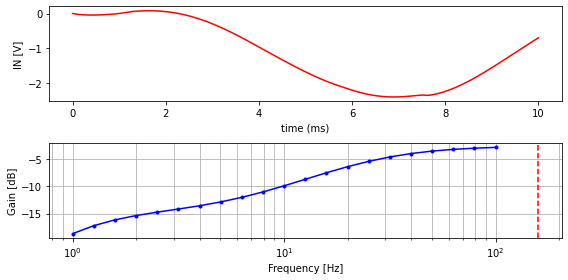

In [19]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['OUT'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)
ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

## low pass filter
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

In [20]:
circuit = Circuit('cmos low pass filter')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2 SIN(0 2V 100)')

circuit.X('1', '4069UB', 'gate_in', 'gate_out', '+5V', circuit.gnd)
circuit.R(2, 'gate_out', 'gate_in', 100@u_kΩ)
circuit.C(1, 'gate_out', 'gate_in', 100@u_nF)
circuit.R(1, 'gate_in', 'IN', 100@u_kΩ);

In [21]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
#TODO remove
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms)
analysis_ac = simulator.ac(start_frequency=10@u_Hz, stop_frequency=500@u_Hz, number_of_points=10,  variation='dec')


2021-03-20 13:18:24,675 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title cmos low pass filter
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 2 SIN(0 2V 100)
X1 gate_in gate_out +5V 0 4069UB
R2 gate_out gate_in 100kOhm
C1 gate_out gate_in 100nF
R1 gate_in IN 100kOhm
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 1Hz 100Hz
.end

2021-03-20 13:18:24,678 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2021-03-20 13:18:24,682 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.load_circuit - DEBUG - ngSpice_Circ
.title cmos low pass filter
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 2 SIN(0 2V 100)
X1 gate_in gate_out +5V 0 4069UB
R2 gate_out gate_in 100kOhm
C1 gate_out gate_in 100nF
R1 gate_in IN 100kOhm
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 1Hz 100Hz
.end

2021-03-20 13

2021-03-20 13:18:25,391 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:18:25,393 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:18:25,396 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


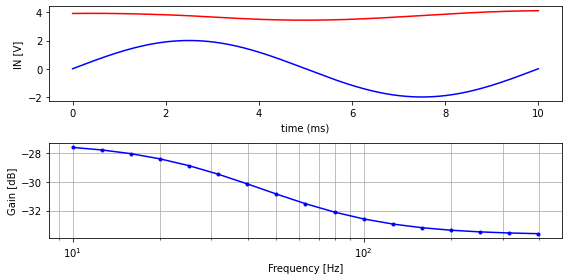

In [22]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
ax1.plot(u_ms(analysis['gate_out'].abscissa), analysis['gate_out'], color='Red')

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['gate_out'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)

plt.tight_layout()
plt.show()

## low pass filter with resonance


2021-03-20 13:18:27,689 - PySpice.Spice.Parser.Element.build - DEBUG - X U1 ['Net-_C1-Pad2_', 'Net-_C1-Pad1_', '+5V', 'GND'] ['4069UB'] {}
2021-03-20 13:18:27,692 - PySpice.Spice.Parser.Element.build - DEBUG - R 2 ['Net-_C1-Pad1_', 'Net-_C1-Pad2_'] ['100k'] {}
2021-03-20 13:18:27,695 - PySpice.Spice.Parser.Element.build - DEBUG - R 1 ['Net-_C1-Pad2_', 'IN'] ['100k'] {}
2021-03-20 13:18:27,698 - PySpice.Spice.Parser.Element.build - DEBUG - C 1 ['Net-_C1-Pad1_', 'Net-_C1-Pad2_'] ['0.01u'] {}
2021-03-20 13:18:27,701 - PySpice.Spice.Parser.Element.build - DEBUG - C 3 ['OUT', 'Net-_C1-Pad1_'] ['1u'] {}
2021-03-20 13:18:27,720 - PySpice.Spice.Parser.Element.build - DEBUG - R 3 ['GND', 'OUT'] ['100k'] {}
2021-03-20 13:18:27,727 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title KiCad schematic
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
XU1 Net-_C1-Pad2_ Net-_C1-Pad1_ +5V GND 4069UB
R2 Net-_C1-Pad1_ Net-_C1-Pad2_ 100k
R1 Net-

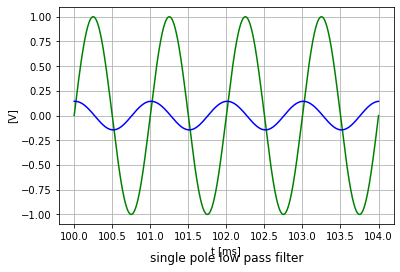

In [23]:
#load single pole low pass filter
kicad_netlist_path = directory_path.joinpath('single pole low pass filter/single pole low pass filter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

lpf_circuit = parser.build_circuit(ground=5)
lpf_circuit.include(spice_library['4069UB'])
lpf_circuit.V('1', '+5V', lpf_circuit.gnd, 'DC 5')
lpf_circuit.V('3', 'IN', lpf_circuit.gnd, 'DC 0V AC 1V SIN(0 1 1k)')

simulator = lpf_circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac_lpf = simulator.ac(start_frequency=10@u_Hz, stop_frequency=500@u_Hz, number_of_points=10,  variation='dec')
analysis_lpf = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=104@u_ms)

fig, axis = plt.subplots(figsize=(6, 4))
axis.plot(u_ms(analysis_lpf['IN'].abscissa), analysis_lpf['IN'], c='Green')
axis.plot(u_ms(analysis_lpf['OUT'].abscissa), analysis_lpf['OUT'], c='Blue')

axis.grid()
axis.set_xlabel('t [ms]')
axis.set_ylabel('[V]')
axis.set_title('single pole low pass filter', y=-0.2)

plt.show()

In [24]:
#r1 = 100@u_kΩ
#c1 = 0.01@u_uF

#cutoff_frequency = solve(Eq(fc, lp_f.subs(R, r1).subs(C, c1).subs(pi,math.pi)))
#Eq(fc, lp_f.subs(R, r1).subs(C, c1).subs(pi,math.pi))


2021-03-20 13:18:31,563 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:18:31,564 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:18:31,565 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less
2021-03-20 13:18:31,567 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'arctan2'> is FLOAT
2021-03-20 13:18:31,569 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


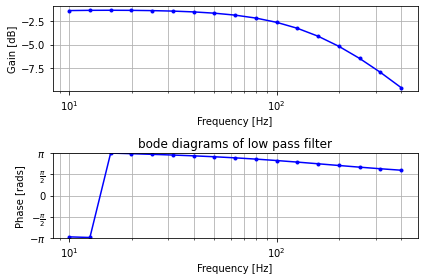

In [25]:
figure, axes = plt.subplots(2, figsize=(6, 4))
plt.title("bode diagrams of low pass filter")
#out = 'Net-_C1-Pad1_'
bode_diagram(axes=axes,
                 frequency=analysis_ac_lpf.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac_lpf['OUT'])),
                 phase=np.angle(analysis_ac_lpf['OUT'], deg=False),
                 marker='.',
                 color='blue',
                 linestyle='-',
    )
#axes[0].axvline(x=cutoff_frequency, color='Red', linestyle='--')
plt.tight_layout()
plt.show()


## low pass filter with resonance


In [26]:
#load resonant low pass filter
kicad_netlist_path = directory_path.joinpath('low pass filter resonance/low pass filter resonance.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

lpf_res_circuit = parser.build_circuit(ground=5)
lpf_res_circuit.include(spice_library['4069UB'])
lpf_res_circuit.V('1', '+5V', lpf_res_circuit.gnd, 'DC 5')
lpf_res_circuit.V('2', 'IN', lpf_res_circuit.gnd, 'DC 0V AC 1V SIN(0 1V 1k)')

#for subcircuit in ( VoltageDivider1(R=100@u_kΩ,w=0.5)):
lpf_res_circuit.subcircuit(VoltageDivider1(R=100@u_kΩ,w=0.5))

simulator = lpf_res_circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac_lpf_res = simulator.ac(start_frequency=10@u_Hz, stop_frequency=500@u_Hz, number_of_points=10,  variation='dec')
analysis_lpf_res = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=104@u_ms)


2021-03-20 13:18:35,165 - PySpice.Spice.Parser.Element.build - DEBUG - X U1 ['Net-_R1-Pad1_', 'Net-_R2-Pad1_', '+5V', 'GND'] ['4069UB'] {}
2021-03-20 13:18:35,168 - PySpice.Spice.Parser.Element.build - DEBUG - R 2 ['Net-_R2-Pad1_', 'Net-_R1-Pad1_'] ['10k'] {}
2021-03-20 13:18:35,172 - PySpice.Spice.Parser.Element.build - DEBUG - R 3 ['Net-_C1-Pad2_', 'Net-_R2-Pad1_'] ['20k'] {}
2021-03-20 13:18:35,176 - PySpice.Spice.Parser.Element.build - DEBUG - X U2 ['Net-_C1-Pad2_', 'Net-_C1-Pad1_', '+5V', 'GND'] ['4069UB'] {}
2021-03-20 13:18:35,178 - PySpice.Spice.Parser.Element.build - DEBUG - X U3 ['Net-_C2-Pad2_', 'OUT', '+5V', 'GND'] ['4069UB'] {}
2021-03-20 13:18:35,181 - PySpice.Spice.Parser.Element.build - DEBUG - C 2 ['OUT', 'Net-_C2-Pad2_'] ['0.01u'] {}
2021-03-20 13:18:35,184 - PySpice.Spice.Parser.Element.build - DEBUG - X RV1 ['NC_01', 'Net-_R4-Pad1_', 'OUT'] ['voltage_divider_1'] {}
2021-03-20 13:18:35,187 - PySpice.Spice.Parser.Element.build - DEBUG - R 1 ['Net-_R1-Pad1_', 'IN'] ['1

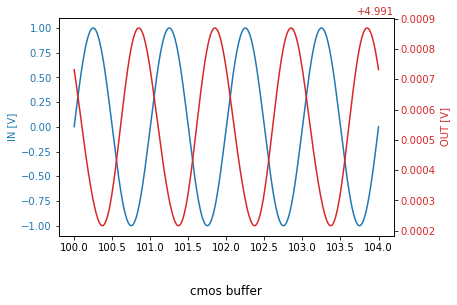

In [27]:
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.set_title('cmos buffer', y=-0.3)

color = 'tab:blue'
ax1.set_ylabel('IN [V]', color=color)
ax1.plot(u_ms(analysis_lpf_res['IN'].abscissa), analysis_lpf_res['IN'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('OUT [V]', color=color)
ax2.plot(u_ms(analysis_lpf_res['OUT'].abscissa), analysis_lpf_res['OUT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

2021-03-20 13:18:40,703 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:18:40,706 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:18:40,708 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less
2021-03-20 13:18:40,710 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'arctan2'> is FLOAT
2021-03-20 13:18:40,712 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


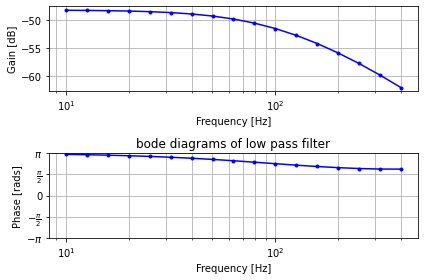

In [28]:
figure, axes = plt.subplots(2, figsize=(6, 4))
plt.title("bode diagrams of low pass filter")
#out = 'Net-_C1-Pad1_'
bode_diagram(axes=axes,
                 frequency=analysis_ac_lpf_res.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac_lpf_res['OUT'])),
                 phase=np.angle(analysis_ac_lpf_res['OUT'], deg=False),
                 marker='.',
                 color='blue',
                 linestyle='-',
    )
#axes[0].axvline(x=cutoff_frequency, color='Red', linestyle='--')
plt.tight_layout()
plt.show()

## band pass filter



## state variable filter

![state variable filter](state variable filter.svg)

In [31]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])
circuit.include(spice_library['TL072'])
circuit.include(spice_library['BC547B'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', '+15V', circuit.gnd, 'DC 15')
circuit.V('3', '-15V', circuit.gnd, 'DC -15')
circuit.V('4', 'CV1', circuit.gnd, 'DC 1')
circuit.V('5', 'CV2', circuit.gnd, 'DC 1')
circuit.V('6', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 100)')

circuit.X(1, 'TL072', circuit.gnd, 'U1n', '+15V', '-15V', 'U1o')
circuit.R(1, 'U1n', 'U1o', 100@u_kΩ)
circuit.X(2, 'TL072', circuit.gnd, 'U2n', '+15V', '-15V', 'U2o')
circuit.R(2, 'U2n', 'U2o', 10@u_kΩ)
circuit.X(3, 'TL072', circuit.gnd, 'U3n', '+15V', '-15V', 'U3o')
circuit.C(1, 'U3n', 'U3o', 2@u_nF)
circuit.X(4, 'TL072', circuit.gnd, 'U4n', '+15V', '-15V', 'U4o')
circuit.C(2, 'U4n', 'U4o', 2@u_nF)

circuit.R(3, 'U1o', 'U2n', 10@u_kΩ)
circuit.R(4, 'U2o', 'R4o', 500@u_Ω)
circuit.R(12, 'CV1', 'R12', 1@u_MΩ)
circuit.BJT('1', 'R4o', 'R12', 'U3n', model="BC547B")
circuit.R(5, 'U3o', 'R5o', 500@u_Ω)
circuit.R(13, 'CV1', 'R13', 1@u_MΩ)
circuit.BJT('2', 'R5o', 'R13', 'U4n', model="BC547B")

#resonance
circuit.R(6, 'U4o', 'U2n', 10@u_kΩ)
circuit.R(14, 'CV2', 'R14', 10@u_kΩ)
circuit.BJT('3', 'U3o', 'R14', 'B1e', model="BC547B")
circuit.R(7, 'B1e', circuit.gnd, 100@u_Ω)
circuit.R(8, 'B1e', 'U1n', 10@u_kΩ)

#input 
circuit.R(9, 'IN', 'R9', 100@u_kΩ)
circuit.R(10, 'R9', circuit.gnd, 1@u_kΩ)
circuit.R(11, 'R9', 'U2n', 10@u_kΩ)


Resistor R11

In [32]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
#TODO remove
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms)
analysis_ac = simulator.ac(start_frequency=10@u_Hz, stop_frequency=500@u_Hz, number_of_points=10,  variation='dec')

2021-03-20 13:19:59,080 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title cmos buffer
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
.include /home/etienne/Documents/elektrophon/lib/spice/opamp/TL072.lib
.include /home/etienne/Documents/elektrophon/lib/spice/transistor/BC547.mod
V1 +5V 0 DC 5
V2 +15V 0 DC 15
V3 -15V 0 DC -15
V4 CV1 0 DC 1
V5 CV2 0 DC 1
V6 IN 0 DC 5 AC 5V SIN(0 5V 100)
X1 0 U1n +15V -15V U1o TL072
R1 U1n U1o 100kOhm
X2 0 U2n +15V -15V U2o TL072
R2 U2n U2o 10kOhm
X3 0 U3n +15V -15V U3o TL072
C1 U3n U3o 2nF
X4 0 U4n +15V -15V U4o TL072
C2 U4n U4o 2nF
R3 U1o U2n 10kOhm
R4 U2o R4o 500Ohm
R12 CV1 R12 1MegOhm
Q1 R4o R12 U3n BC547B
R5 U3o R5o 500Ohm
R13 CV1 R13 1MegOhm
Q2 R5o R13 U4n BC547B
R6 U4o U2n 10kOhm
R14 CV2 R14 10kOhm
Q3 U3o R14 B1e BC547B
R7 B1e 0 100Ohm
R8 B1e U1n 10kOhm
R9 IN R9 100kOhm
R10 R9 0 1kOhm
R11 R9 U2n 10kOhm
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 1Hz 100Hz
.end

2021-03-20

2021-03-20 13:20:24,102 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:20:24,103 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:20:24,104 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less
2021-03-20 13:20:24,111 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:20:24,112 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 13:20:24,113 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less
2021-03-20 13:20:24,119 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2021-03-20 13:20:24,120 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2021-03-20 

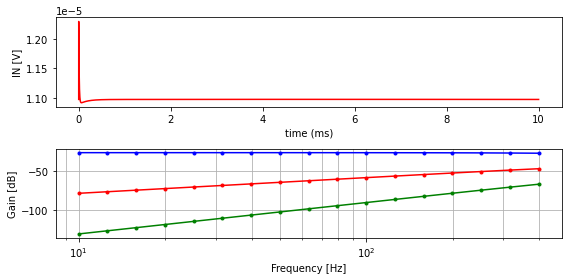

In [33]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
#ax1.plot(u_ms(analysis['U4o'].abscissa), analysis['U4o'], color='Red')
ax1.plot(u_ms(analysis['U2n'].abscissa), analysis['U2n'], color='Red')


bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['U4o'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['U2o'])),
                 marker='.',
                 color='green',
                 linestyle='-',
)


bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['U3o'])),
                 marker='.',
                 color='red',
                 linestyle='-',
)

plt.tight_layout()
plt.show()